In [1]:
import numpy as np
import netCDF4 as nc
import datetime as dt
import pandas as pd

from sklearn.cluster import KMeans
#import mpl_toolkits.mplot3d as mpl3d

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline

In [2]:
rootdir = '/raid1/chen423/serdp/archive/GRL2018/'

In [3]:
def get_nc_data(infile, var):
    tmpgroup = nc.Dataset(infile, 'r', format='NETCDF4')
    outdata = tmpgroup.variables[var][:]
    tmpgroup.close()
    return outdata

### classification functions

In [4]:
def normalize_input_various_method(indata, method):
    # only handles 1-d array
    
    if method=='meanstd':
        outdata = (indata-np.mean(indata))/np.std(indata)
    
    if method=='uniform':
        outdata = (indata-np.min(indata))/(np.max(indata)-np.min(indata))
    
    if method=='cdf':
        outdata = np.ones(indata.shape)*9999
        for i in np.arange(indata.shape[0]):
            outdata[i] = ((indata<=indata[i]).sum())/indata.shape[0]
        
    return outdata

### plots

In [5]:
dic_feature_id = {'area (whole)':0, 'area (land)':1, 'intensity (whole)':2, 'intensity (land)':3, 'coastal width':4,
                  'coastal intensity':5, 'start time':6, 'duration':7, 'center time':8, 'center lat':9, 'center lon':10}

In [6]:
def AR_classification(nclass, ARfeature_full, indic):
    nfeatures = len(indic.keys())
    ARfeature_norm = np.zeros((ARfeature_full.shape[0], nfeatures))
    for f in np.arange(nfeatures):
        tmp_feature = list(indic.keys())[f]
        #print(tmp_feature, dic_feature_id[tmp_feature], indic[tmp_feature])
        ARfeature_norm[:,f] = normalize_input_various_method(ARfeature_full[:,dic_feature_id[tmp_feature]], indic[tmp_feature])

    kmean_model = KMeans(n_clusters=nclass, random_state=0)
    kmean_results = kmean_model.fit(ARfeature_norm)

    return kmean_results.labels_, ARfeature_norm, list(indic.keys())

In [7]:
def consistent_AR_class_order(indata, order):
    # use: to make the AR class index consistent between different datasets.
    outdata = np.ones(indata.shape, dtype=np.int32)*9999
    outdata[indata==0] = 9990
    outdata[indata==1] = 9991
    outdata[indata==2] = 9992
    for i in np.arange(3):
        outdata[outdata==(9990+order[i])] = int(i)
    return outdata

In [8]:
def split_AR_ns(ARfeature_full):
    # taking 40 as split
    latbound = 40.0
    ARlat = ARfeature_full[:,9]
    nfeatures = ARfeature_full.shape[1]
    nnorth = (ARlat>latbound).sum()
    nsouth = (ARlat<=latbound).sum()
    ARfeature_north = np.zeros((nnorth, nfeatures))
    ARfeature_south = np.zeros((nsouth, nfeatures))
    
    count_n = 0
    count_s = 0
    
    for i in np.arange(ARfeature_full.shape[0]):
        if ARfeature_full[i,9]<=latbound:
            ARfeature_south[count_s,:] = ARfeature_full[i,:]
            count_s = count_s + 1
        elif ARfeature_full[i,9]>latbound:
            ARfeature_north[count_n,:] = ARfeature_full[i,:]
            count_n = count_n + 1
    
    return ARfeature_north, ARfeature_south

In [9]:
def visualize_feature_hist(nclasses, kmean_result, feature, feature_names, nstd, ymaxs):

    colors = ['royalblue', 'lightseagreen', 'orange', 'fuchsia']
    #nstd = 6
    xmins = [-1*nstd,-1*nstd]
    xmaxs = [nstd, nstd]
    bins = np.arange(-1*nstd,nstd+0.1,0.25)
    ymins = [0,0,0,0]

    fig_handle = plt.figure(figsize=(3.5*len(feature_names),nclasses*3))

    count = 1
    for x in np.arange(nclasses):
        ymin = ymins[x]
        ymax = ymaxs[x]
        for y in np.arange(len(feature_names)):
            ax = fig_handle.add_subplot(nclasses,len(feature_names),count)
            color = colors[x]
            xmin = xmins[y]
            xmax = xmaxs[y]
            ax.hist(feature[:,y][np.where(kmean_result==x)], bins, color=color)
            ax.plot((0,0), (0,6000), '--', color='black')
            ax.plot((1,1), (0,6000), '-', color='gray', linewidth=1, alpha=0.6)
            ax.plot((-1,-1), (0,6000), '-', color='gray', linewidth=1, alpha=0.6)
            ax.set_xlim([xmin, xmax])
            ax.set_ylim([ymin, ymax])
            if x!=nclasses-1:
                ax.set_xticklabels([])
            else:
                ax.xaxis.set_tick_params(labelsize=10)
                ax.set_xlabel('Normalized '+feature_names[y], size=12)
            if y>0:
                ax.set_yticklabels([])
            else:
                ax.yaxis.set_tick_params(labelsize=10)
                ax.set_ylabel('# of events', size=12)
            count = count + 1

    plt.tight_layout()
    
    return fig_handle

## main functions

In [10]:
def derive_classified_AR(method):
    infile = rootdir+'data/AR_features/part2/%s.AR_events_feature.1981-2015.nc' % (method)
    ARfeature_full = get_nc_data(infile, 'AR_event_feature')
    ARfeature_north, ARfeature_south = split_AR_ns(ARfeature_full)

    # north
    AR_class_index_n_raw, ARfeature_norm_n, ARfeature_names = AR_classification(3, ARfeature_north, {'duration':'meanstd', 'intensity (land)':'meanstd'})
    AR_class_index_n = consistent_AR_class_order(AR_class_index_n_raw, conversion_orders_n[method])
    
    # south
    AR_class_index_s_raw, ARfeature_norm_s, ARfeature_names = AR_classification(3, ARfeature_south, {'duration':'meanstd', 'intensity (land)':'meanstd'})
    AR_class_index_s = consistent_AR_class_order(AR_class_index_s_raw, conversion_orders_s[method])
    
    return AR_class_index_n, ARfeature_norm_n, AR_class_index_s, ARfeature_norm_s, ARfeature_names

In [51]:
# GRL data version
#conversion_orders_n = {'rutz':[2,0,1], 'gershunov':[0,1,2], 'guan':[0,2,1],
#                       'goldenson':[0,1,2], 'pnnl1':[1,0,2], 'pnnl2':[2,1,0],
#                       'lora':[0,1,2], 'payne':[0,2,1], 'tempest':[1,0,2], 'walton':[0,2,1]}

#conversion_orders_s = {'rutz':[0,2,1], 'gershunov':[1,0,2], 'guan':[0,2,1],
#                       'goldenson':[1,2,0], 'pnnl1':[2,0,1], 'pnnl2':[1,2,0],
#                       'lora':[0,1,2], 'payne':[0,2,1], 'tempest':[0,1,2], 'walton':[1,2,0]}

# updated version
conversion_orders_n = {'rutz':[0,2,1], 'gershunov':[0,2,1], 'guan':[2,0,1],
                       'goldenson':[0,1,2], 'pnnl1':[0,2,1], 'pnnl2':[0,1,2],
                       'lora':[0,1,2], 'payne':[0,2,1], 'tempest':[0,1,2], 'walton':[0,1,2]}

conversion_orders_s = {'rutz':[1,0,2], 'gershunov':[0,1,2], 'guan':[2,1,0],
                       'goldenson':[0,1,2], 'pnnl1':[0,2,1], 'pnnl2':[0,1,2],
                       'lora':[0,1,2], 'payne':[0,2,1], 'tempest':[0,2,1], 'walton':[1,0,2]}

AR_class_name = ['weak','flash','prolong']

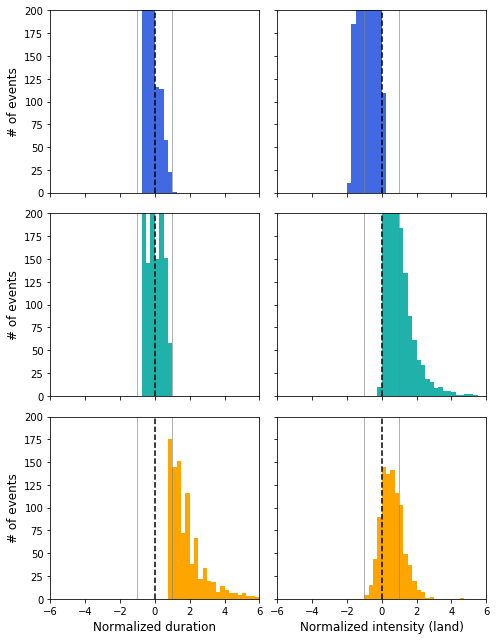

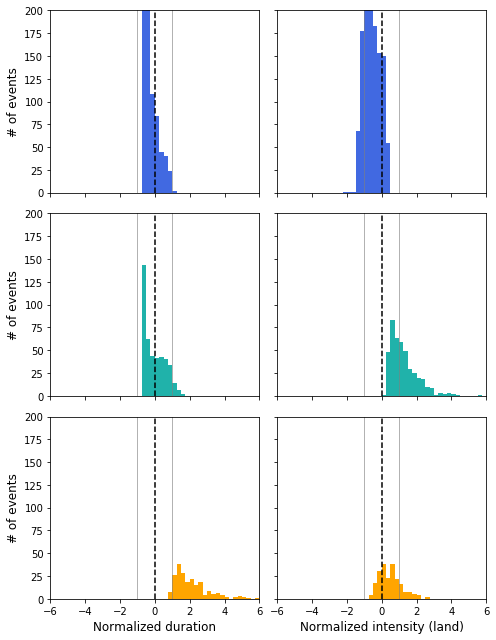

In [52]:
method = 'rutz'

AR_class_index_n, ARfeature_norm_n, AR_class_index_s, ARfeature_norm_s, ARfeature_names = derive_classified_AR(method)

fig1 = visualize_feature_hist(3, AR_class_index_n, ARfeature_norm_n, ARfeature_names, 6, [200,200,200])
fig2 = visualize_feature_hist(3, AR_class_index_s, ARfeature_norm_s, ARfeature_names, 6, [200,200,200])

### save results to a netcdf file for easy retrieval

In [53]:
def save_ARclassification_north(method):
    outfile = rootdir+'data/AR_classification/north_south_split/AR_3class.north.%s.nc' % (method)
    
    outgroup = nc.Dataset(outfile, 'w', format='NETCDF4')
    
    # dimensions
    nedim = outgroup.createDimension('ARevent', None)
    fsdim = outgroup.createDimension('ARfeature_selected', 2)
    
    # dim vars
    nevar = outgroup.createVariable('ARevent', 'i4', ('ARevent'))
    nevar[:] = np.arange(AR_class_index_n.shape[0])
    fsvar = outgroup.createVariable('ARfeature_selected', 'S2', ('ARfeature_selected'))
    fsvar[0] = 'duration'
    fsvar[1] = 'intensity (land)'
    
    # variables
    ARvar_index = outgroup.createVariable('ARclass_index', 'i4', ('ARevent'))
    ARvar_index.description = '0->weak AR;  1->flash AR;  2->prolonged AR'
    ARvar_index[:] = AR_class_index_n
    
    ARvar_fnorm = outgroup.createVariable('ARfeature_norm', 'f4', ('ARevent', 'ARfeature_selected'))
    ARvar_fnorm.description = 'normalized using meanstd approach. see paper1_experiments/Regression_with_AR/Step3_AR_classification.module.north_south_split.ipynb for details'
    ARvar_fnorm[:] = ARfeature_norm_n
    ARvar_fnorm.dim1 = 'duration'
    ARvar_fnorm.dim2 = 'intensity (land)'
    
    outgroup.note = 'ARfeature_full taken from '+rootdir+'data/AR_features/part2/<method>.AR_events_feature.1981-2015.nc'
    outgroup.script = rootdir+'scripts/step3-ns.AR_classification.module.north_south_split.ipynb'
    
    outgroup.close()

    
def save_ARclassification_south(method):
    outfile = rootdir+'data/AR_classification/north_south_split/AR_3class.south.%s.nc' % (method)
    
    outgroup = nc.Dataset(outfile, 'w', format='NETCDF4')
    
    # dimensions
    nedim = outgroup.createDimension('ARevent', None)
    fsdim = outgroup.createDimension('ARfeature_selected', 2)
    
    # dim vars
    nevar = outgroup.createVariable('ARevent', 'i4', ('ARevent'))
    nevar[:] = np.arange(AR_class_index_s.shape[0])
    fsvar = outgroup.createVariable('ARfeature_selected', 'S2', ('ARfeature_selected'))
    fsvar[0] = 'duration'
    fsvar[1] = 'intensity (land)'
    
    # variables
    ARvar_index = outgroup.createVariable('ARclass_index', 'i4', ('ARevent'))
    ARvar_index.description = '0->weak AR;  1->flash AR;  2->prolonged AR'
    ARvar_index[:] = AR_class_index_s
    
    ARvar_fnorm = outgroup.createVariable('ARfeature_norm', 'f4', ('ARevent', 'ARfeature_selected'))
    ARvar_fnorm.description = 'normalized using meanstd approach. see paper1_experiments/Regression_with_AR/Step3_AR_classification.module.north_south_split.ipynb for details'
    ARvar_fnorm[:] = ARfeature_norm_s
    ARvar_fnorm.dim1 = 'duration'
    ARvar_fnorm.dim2 = 'intensity (land)'
    
    outgroup.note = 'ARfeature_full taken from '+rootdir+'data/AR_features/part2/<method>.AR_events_feature.1981-2015.nc'
    outgroup.script = rootdir+'scripts/step3-ns.AR_classification.module.north_south_split.ipynb'
    
    outgroup.close()

In [54]:
methods = ['rutz','gershunov','guan','goldenson','pnnl1','pnnl2','lora','payne','tempest','walton']

for method in methods:
    print(method)
    AR_class_index_n, ARfeature_norm_n, AR_class_index_s, ARfeature_norm_s, ARfeature_names = derive_classified_AR(method)
    save_ARclassification_north(method)
    save_ARclassification_south(method)

rutz
gershunov
guan
goldenson
pnnl1
pnnl2
lora
payne
tempest
walton
